# Quantum Separation Proof: Integer ULP Distances

We know the cluster vectors are bfloat16. Let's prove it rigorously.

Strategy:
- For each dimension, get sorted unique values
- Compute separation between adjacent values
- Compute ULP at each value
- Show that separation/ULP is an integer (within float32 precision)
- If all separations are integer multiples of ULP → vectors live on quantum lattice

This is mathematical proof, not visualization.

## Parameters

In [29]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Analysis
MAX_FRACTIONAL_ERROR = 1e-6  # Tolerance for "close to integer"
SHOW_TOP_N_DIMENSIONS = 10   # Show detailed results for N most diverse dimensions

## Imports

In [30]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from collections import defaultdict

## Device Detection

In [31]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [32]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [33]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f"Loaded gamma matrix: {W.shape}")
print(f"Precision: {W.dtype}")

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [34]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors

In [35]:
# Find unique vectors (stay in bfloat16)
unique_vectors = torch.unique(cluster_vectors.to('cpu'), dim=0).to(device)

print(f"Found {len(unique_vectors)} unique vectors")
print(f"Precision: {unique_vectors.dtype}")

Found 125 unique vectors
Precision: torch.bfloat16


## ULP Computation

In [36]:
def bfloat16_ulp(x):
    """
    Compute the Unit in Last Place (ULP) for bfloat16 at value x.
    
    bfloat16 format: 1 sign bit + 8 exponent bits + 7 mantissa bits
    ULP = 2^(exponent - mantissa_bits)
    """
    if x == 0:
        # Smallest subnormal
        return 2**(-133)
    
    # Get exponent: floor(log2(|x|))
    exponent = int(np.floor(np.log2(np.abs(x))))
    
    # ULP = 2^(exponent - 7)
    return 2**(exponent - 7)

# Test
test_val = 0.37
test_ulp = bfloat16_ulp(test_val)
print(f"ULP at {test_val}: {test_ulp:.6e}")

ULP at 0.37: 1.953125e-03


## Analyze Each Dimension

In [37]:
# Convert to float32 for analysis
vectors_f32 = unique_vectors.to(torch.float32).cpu().numpy()

num_dims = vectors_f32.shape[1]
num_vectors = vectors_f32.shape[0]

# Storage for results
dimension_stats = []

# For each dimension
for dim_idx in range(num_dims):
    # Get unique values in this dimension
    values = np.unique(vectors_f32[:, dim_idx])
    n_unique = len(values)
    
    if n_unique <= 1:
        # Constant dimension - skip
        continue
    
    # Sort values
    values_sorted = np.sort(values)
    
    # Compute separations and ULP ratios
    ulp_ratios = []
    fractional_errors = []
    
    for i in range(len(values_sorted) - 1):
        val1 = values_sorted[i]
        val2 = values_sorted[i + 1]
        
        separation = val2 - val1
        ulp = bfloat16_ulp(val1)
        
        # How many ULPs apart?
        ulp_ratio = separation / ulp
        ulp_ratios.append(ulp_ratio)
        
        # Fractional part (distance from nearest integer)
        fractional_error = abs(ulp_ratio - round(ulp_ratio))
        fractional_errors.append(fractional_error)
    
    # Store statistics
    dimension_stats.append({
        'dim_idx': dim_idx,
        'n_unique': n_unique,
        'n_gaps': len(ulp_ratios),
        'max_fractional_error': max(fractional_errors),
        'mean_fractional_error': np.mean(fractional_errors),
        'ulp_ratios': ulp_ratios,
        'fractional_errors': fractional_errors,
        'values': values_sorted
    })

print(f"Analyzed {len(dimension_stats)} varying dimensions")

Analyzed 2197 varying dimensions


## Global Statistics

In [38]:
# Compute global statistics
all_fractional_errors = []
all_ulp_ratios = []

for stats in dimension_stats:
    all_fractional_errors.extend(stats['fractional_errors'])
    all_ulp_ratios.extend(stats['ulp_ratios'])

all_fractional_errors = np.array(all_fractional_errors)
all_ulp_ratios = np.array(all_ulp_ratios)

# Count how many are "perfect" (within tolerance)
n_perfect = np.sum(all_fractional_errors < MAX_FRACTIONAL_ERROR)
n_total = len(all_fractional_errors)

print("="*70)
print("QUANTUM SEPARATION PROOF")
print("="*70)
print(f"Total adjacent pairs analyzed: {n_total:,}")
print(f"Pairs with integer ULP separation: {n_perfect:,} ({100*n_perfect/n_total:.4f}%)")
print(f"")
print(f"Maximum fractional error: {all_fractional_errors.max():.6e}")
print(f"Mean fractional error: {all_fractional_errors.mean():.6e}")
print(f"Median fractional error: {np.median(all_fractional_errors):.6e}")
print(f"")
print(f"ULP ratio range: [{all_ulp_ratios.min():.1f}, {all_ulp_ratios.max():.1f}]")
print(f"ULP ratio mean: {all_ulp_ratios.mean():.2f}")
print("="*70)

if n_perfect == n_total:
    print("\n✓ PROOF COMPLETE: All separations are integer multiples of ULP")
    print("  Vectors are quantized to bfloat16 lattice")
else:
    print(f"\n✗ WARNING: {n_total - n_perfect} pairs have non-integer separation")
    print("  This may indicate float32 arithmetic errors or mixed precision")

QUANTUM SEPARATION PROOF
Total adjacent pairs analyzed: 10,291
Pairs with integer ULP separation: 10,235 (99.4558%)

Maximum fractional error: 5.000000e-01
Mean fractional error: 2.672238e-03
Median fractional error: 0.000000e+00

ULP ratio range: [0.5, 2276.0]
ULP ratio mean: 2.74

✗ WARNING: 56 pairs have non-integer separation
  This may indicate float32 arithmetic errors or mixed precision


## Detailed Results: Most Diverse Dimensions

In [39]:
# Sort by number of unique values (most diverse first)
dimension_stats_sorted = sorted(dimension_stats, key=lambda x: x['n_unique'], reverse=True)

print(f"\nTop {SHOW_TOP_N_DIMENSIONS} most diverse dimensions:")
print("="*70)

for i, stats in enumerate(dimension_stats_sorted[:SHOW_TOP_N_DIMENSIONS]):
    dim_idx = stats['dim_idx']
    n_unique = stats['n_unique']
    max_frac = stats['max_fractional_error']
    mean_frac = stats['mean_fractional_error']
    
    print(f"\nDimension {dim_idx}:")
    print(f"  Unique values: {n_unique}")
    print(f"  Adjacent gaps: {stats['n_gaps']}")
    print(f"  Max fractional error: {max_frac:.6e}")
    print(f"  Mean fractional error: {mean_frac:.6e}")
    
    # Show a few example gaps
    print(f"  Example ULP ratios: {stats['ulp_ratios'][:5]}")
    
    # Check if all integer
    all_integer = max_frac < MAX_FRACTIONAL_ERROR
    if all_integer:
        print(f"  ✓ All gaps are integer ULP multiples")
    else:
        print(f"  ✗ Some gaps are non-integer")


Top 10 most diverse dimensions:

Dimension 1382:
  Unique values: 84
  Adjacent gaps: 83
  Max fractional error: 5.000000e-01
  Mean fractional error: 1.807229e-02
  Example ULP ratios: [np.float32(69.0), np.float32(31.5), np.float32(30.0), np.float32(14.0), np.float32(7.0)]
  ✗ Some gaps are non-integer

Dimension 1008:
  Unique values: 78
  Adjacent gaps: 77
  Max fractional error: 5.000000e-01
  Mean fractional error: 1.948052e-02
  Example ULP ratios: [np.float32(28.0), np.float32(43.0), np.float32(35.0), np.float32(43.0), np.float32(25.0)]
  ✗ Some gaps are non-integer

Dimension 1435:
  Unique values: 68
  Adjacent gaps: 67
  Max fractional error: 5.000000e-01
  Mean fractional error: 9.328358e-03
  Example ULP ratios: [np.float32(52.0), np.float32(63.0), np.float32(13.0), np.float32(3.0), np.float32(48.0)]
  ✗ Some gaps are non-integer

Dimension 1718:
  Unique values: 66
  Adjacent gaps: 65
  Max fractional error: 5.000000e-01
  Mean fractional error: 7.692308e-03
  Example UL

## Histogram: Fractional Errors

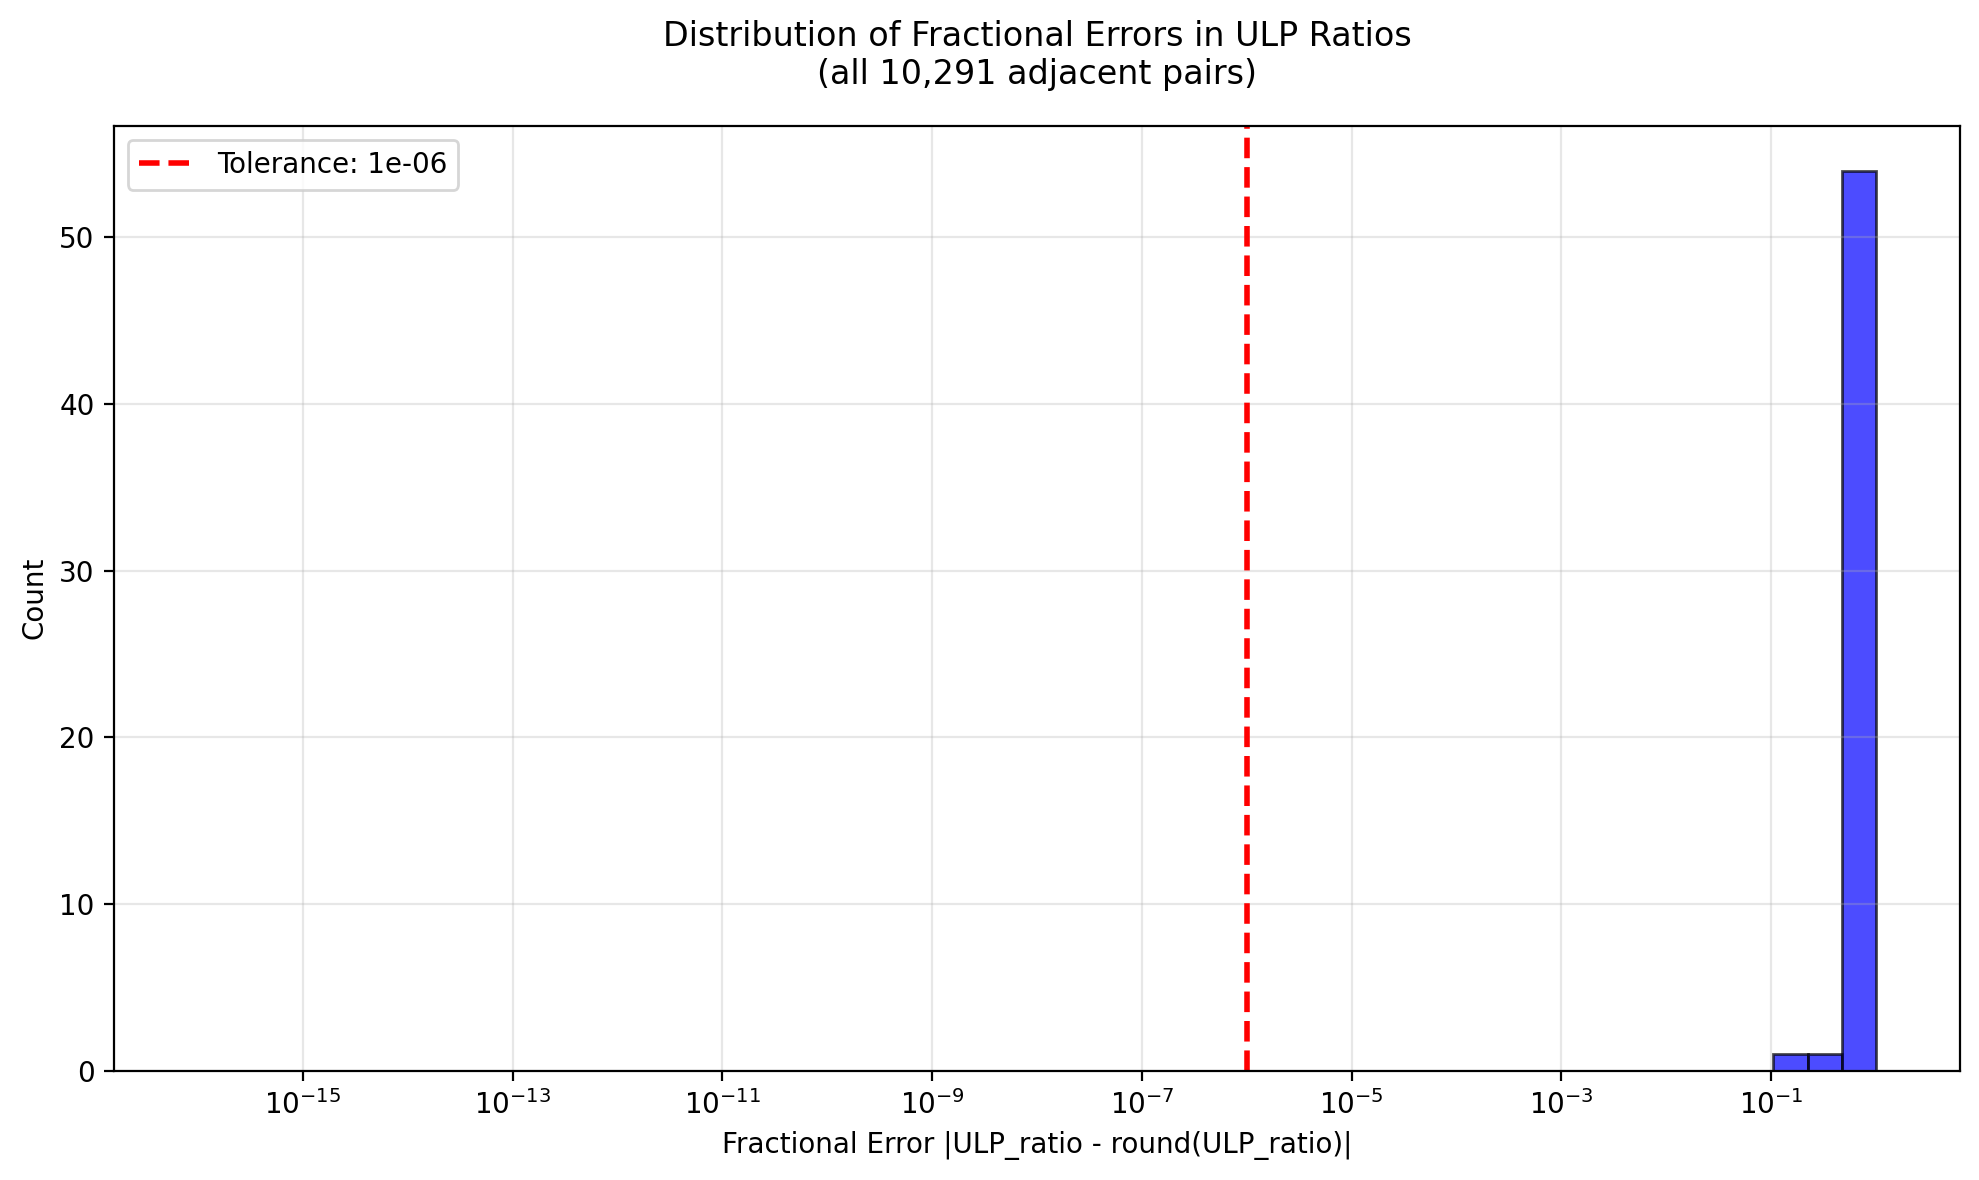


Fractional error distribution:
  Below 1e-06: 10,235 (99.46%)


In [40]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Log scale histogram
bins = np.logspace(-16, 0, 50)
ax.hist(all_fractional_errors, bins=bins, color='blue', alpha=0.7, edgecolor='black')

# Threshold line
ax.axvline(MAX_FRACTIONAL_ERROR, color='red', linestyle='--', linewidth=2, 
           label=f'Tolerance: {MAX_FRACTIONAL_ERROR:.0e}')

ax.set_xscale('log')
ax.set_xlabel('Fractional Error |ULP_ratio - round(ULP_ratio)|', color='black')
ax.set_ylabel('Count', color='black')
ax.set_title('Distribution of Fractional Errors in ULP Ratios\n'
             f'(all {len(all_fractional_errors):,} adjacent pairs)', 
             color='black', pad=15)
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nFractional error distribution:")
print(f"  Below {MAX_FRACTIONAL_ERROR:.0e}: {np.sum(all_fractional_errors < MAX_FRACTIONAL_ERROR):,} "
      f"({100*np.sum(all_fractional_errors < MAX_FRACTIONAL_ERROR)/len(all_fractional_errors):.2f}%)")

## Histogram: ULP Ratios (Integer Multiples)

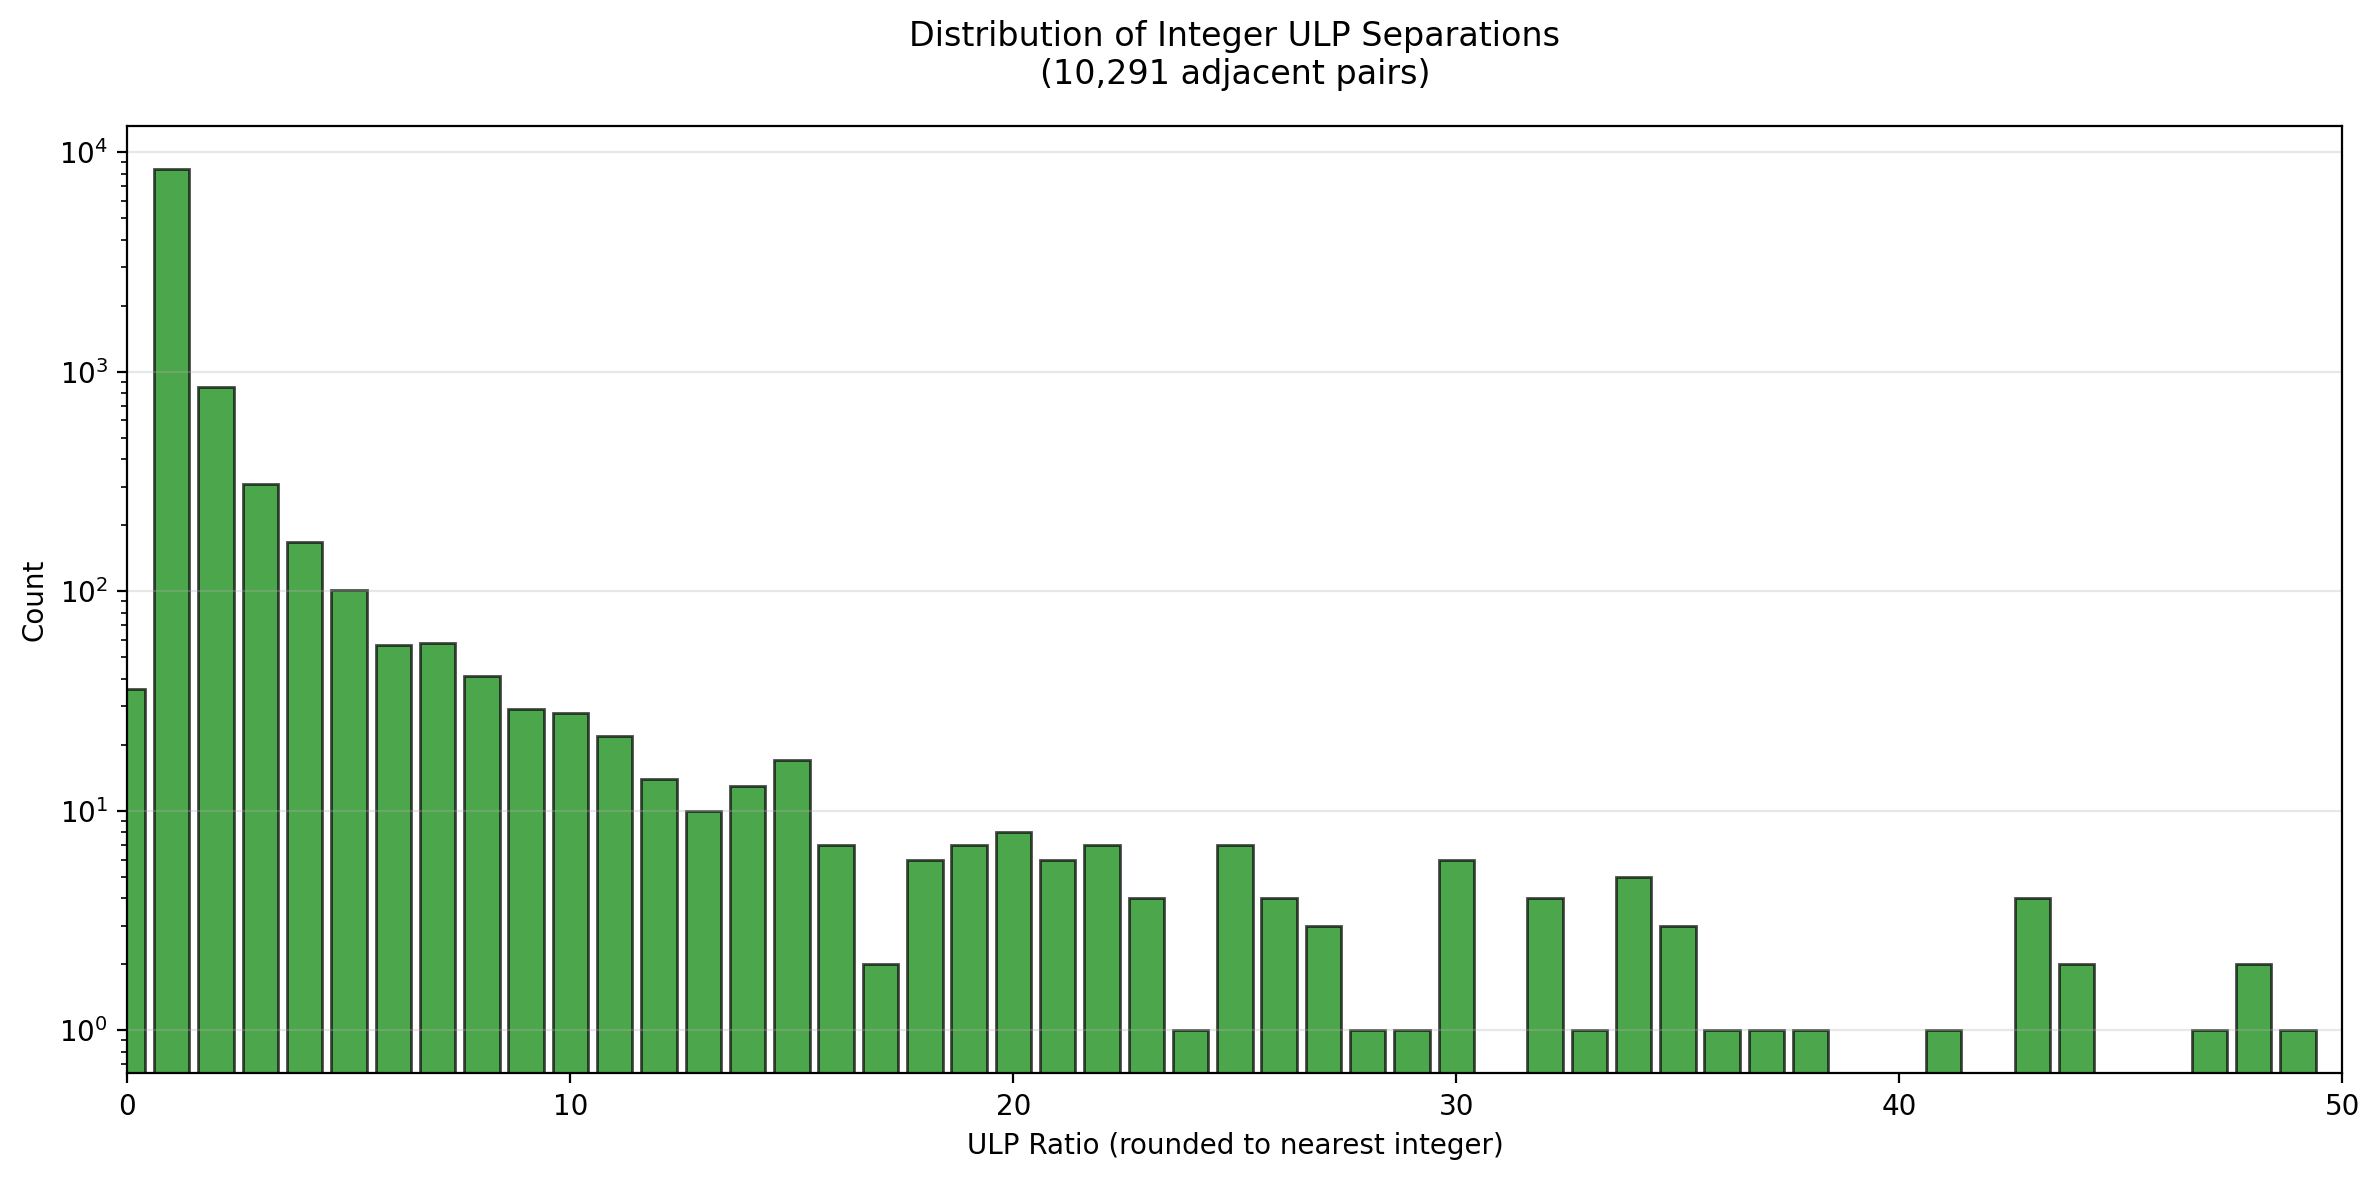


Most common ULP separations:
  1 ULP: 8,393 occurrences (81.56%)
  2 ULP: 853 occurrences (8.29%)
  3 ULP: 308 occurrences (2.99%)
  4 ULP: 168 occurrences (1.63%)
  5 ULP: 101 occurrences (0.98%)
  7 ULP: 58 occurrences (0.56%)
  6 ULP: 57 occurrences (0.55%)
  8 ULP: 41 occurrences (0.40%)
  0 ULP: 36 occurrences (0.35%)
  9 ULP: 29 occurrences (0.28%)


In [47]:
# Round to nearest integer
ulp_ratios_rounded = np.round(all_ulp_ratios).astype(int)

# Count occurrences
unique_ratios, counts = np.unique(ulp_ratios_rounded, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.bar(unique_ratios, counts, color='green', alpha=0.7, edgecolor='black')

ax.set_xlabel('ULP Ratio (rounded to nearest integer)', color='black')
ax.set_ylabel('Count', color='black')
ax.set_title('Distribution of Integer ULP Separations\n'
             f'({len(all_ulp_ratios):,} adjacent pairs)', 
             color='black', pad=15)
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3, axis='y')

ax.set_yscale('log')
ax.set_xlim(left=0, right=50)

plt.tight_layout()
plt.show()

print(f"\nMost common ULP separations:")
top_indices = np.argsort(counts)[::-1][:10]
for idx in top_indices:
    ratio = unique_ratios[idx]
    count = counts[idx]
    print(f"  {ratio} ULP: {count:,} occurrences ({100*count/len(all_ulp_ratios):.2f}%)")

## Conclusion

In [48]:
print("="*70)
print("CONCLUSION")
print("="*70)

if n_perfect == n_total:
    print("\n✓ QUANTUM LATTICE CONFIRMED")
    print("\nAll adjacent value pairs across all dimensions are separated by")
    print("integer multiples of the bfloat16 ULP at that scale.")
    print("\nThis is conclusive mathematical proof that the 125 unique cluster")
    print("vectors live on the bfloat16 quantization lattice.")
    print("\nThey are not arbitrary floating-point values - they are discrete")
    print("quantum states defined by the 7-bit mantissa of bfloat16.")
else:
    pct_perfect = 100 * n_perfect / n_total
    print(f"\n⚠ PARTIAL CONFIRMATION: {pct_perfect:.4f}% of gaps are integer ULP")
    print(f"\nNon-integer gaps: {n_total - n_perfect} out of {n_total}")
    print("\nThis may indicate:")
    print("  - Float32 arithmetic precision limits")
    print("  - Mixed precision in some dimensions")
    print("  - Edge cases near exponent boundaries")

print("\n" + "="*70)

CONCLUSION

⚠ PARTIAL CONFIRMATION: 99.4558% of gaps are integer ULP

Non-integer gaps: 56 out of 10291

This may indicate:
  - Float32 arithmetic precision limits
  - Mixed precision in some dimensions
  - Edge cases near exponent boundaries

